# <font color="green"> This notebook is used to perform additional cleaning of statements

In [ ]:
%load_ext autoreload
%autoreload 2

In [47]:
import pandas as pd
from os import getcwd
import numpy as np
from tqdm import tqdm
import re
from typing import Tuple, Dict, Sequence, List, Union
from copy import deepcopy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import factorial

In [3]:
from modern_slavery_registry.utils import (generate_hash,
                                           sort_dict)

In [4]:
DATA_PATH = getcwd()
DATA_PATH = DATA_PATH.replace("notebooks", "")
DATA_PATH += "data"
SHEETS_PATH = DATA_PATH + "\\sheets"

In [207]:
data = pd.read_excel(f"{SHEETS_PATH}\\combined_modern_slavery_statements.xlsx")
data.fillna("#NA", inplace=True)
data["duplicate_statement"] = data.duplicated(subset="URL")

In [208]:
data.head(3)

,Company ID,Company,Statement ID,URL,statement(Edgar),statement(Nitin),final_statement,final_statement(E/N),final_statement_cleaned,duplicate_statement
0,7676,"""K"" Line Holding Europe Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,False
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,True
2,28659,"""K"" Line (Europe) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,True


In [209]:
print("Before cleaning")
print(f"Total non-NA final_statements: {np.sum((data['final_statement_cleaned'] != '#NA'))}")

print("Number of non-NA final_statements(E): "
      f"{np.sum((data['final_statement_cleaned'] != '#NA') & (data['final_statement(E/N)'] == 'E'))}")

print("Number of non-NA final_statements(N): "
      f"{np.sum((data['final_statement_cleaned'] != '#NA') & (data['final_statement(E/N)'] == 'N'))}")

Before cleaning
Total non-NA final_statements: 20699
Number of non-NA final_statements(E): 18619
Number of non-NA final_statements(N): 2080


In [210]:
print("Number of non-NA unique statements : "
      f"{np.sum((data['final_statement_cleaned']!='#NA') & (data['duplicate_statement']==False))}")

print("Number of non-NA duplicate statements : "
      f"{np.sum((data['final_statement_cleaned']!='#NA') & (data['duplicate_statement']==True))}")

Number of non-NA unique statements : 11967
Number of non-NA duplicate statements : 8732


# Selecting unique statements

In [211]:
subset_data = data[data["final_statement_cleaned"]!="#NA"][["URL", "final_statement_cleaned"]].copy()
subset_data.drop_duplicates(subset="URL", inplace=True)
subset_data.head(6)

,URL,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...
14,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...


# Lemmatizing

In [215]:
lemmatizer = WordNetLemmatizer() # wordnet lemmatizer object
cleaned_statements = []
for statement in tqdm(subset_data["final_statement_cleaned"], position=0, leave=True):
    cleaned_statements.append(
        " ".join(
            lemmatizer.lemmatize(word, pos="v") for word in statement.split()))

100%|███████████████████████████████████████████████████████████████████████████| 11967/11967 [00:43<00:00, 275.04it/s]


In [216]:
word_sizes = {}
vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1733.49it/s]


In [217]:
word_sizes = sort_dict(word_sizes, by=0)

In [218]:
print(f"Total vocab size: {len(vocab)}, total distinct word sizes: {len(word_sizes)}")

Total vocab size: 54691, total distinct word sizes: 85


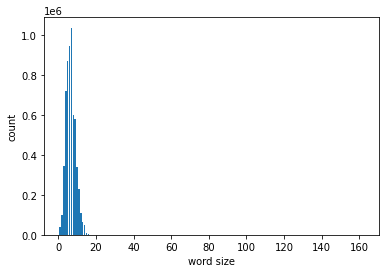

In [219]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

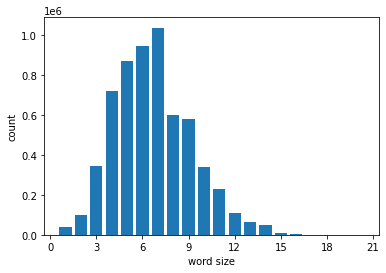

In [220]:
fig, ax = plt.subplots()
ax.bar(list(word_sizes.keys())[:20], list(word_sizes.values())[:20])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [221]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15

In [222]:
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 5634.17it/s]


In [223]:
sub_word_sizes = {}
sub_vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in sub_vocab:
            sub_vocab[word] = 1
        else:
            sub_vocab[word] += 1
        if size not in sub_word_sizes:
            sub_word_sizes[size] = 1
        else:
            sub_word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1777.10it/s]


In [224]:
sub_word_sizes = sort_dict(sub_word_sizes, by=0)
sub_vocab = sort_dict(sub_vocab, by=1, reverse=True)

In [225]:
print(f"Total vocab size: {len(sub_vocab)}, total distinct word sizes: {len(sub_word_sizes)}")

Total vocab size: 52443, total distinct word sizes: 14


In [229]:
subset_data["final_statement_cleaned_2"] = cleaned_statements

In [230]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...


# Generating similarity score between statements

In [231]:
N_GRAM = (1, 1)
count_vect = CountVectorizer(ngram_range=N_GRAM)
X = count_vect.fit_transform(subset_data["final_statement_cleaned_2"])

In [232]:
print(f"Count vector shape: {X.shape}")

Count vector shape: (11967, 52443)


In [233]:
similarity_matrix = cosine_similarity(X, X)

# Tagging almost duplicate statements using similarity score

In [240]:
DUPLICATE_SIMILARITY_SCORE_THRESHOLD = .99
n = X.shape[0]
dup_mapping = {} 
dup_idxs = []
for idx in tqdm(range(n), position=0, leave=True):
    if idx not in dup_idxs:
        idxs = np.argwhere(similarity_matrix[idx][idx+1:] > DUPLICATE_SIMILARITY_SCORE_THRESHOLD).ravel()
        if len(idxs) > 0:
            idxs += idx+1 # shifting
            dup_mapping[idx] = idxs
            dup_idxs += list(idxs)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 4468.60it/s]


In [268]:
print(f"Found {len(dup_idxs)} out of {len(subset_data)} with {DUPLICATE_SIMILARITY_SCORE_THRESHOLD*100}% duplicacy")

Found 1191 out of 11967 with 99.0% duplicacy


In [253]:
subset_data[f"{DUPLICATE_SIMILARITY_SCORE_THRESHOLD}%dup"] = [True if idx in dup_idxs else False for idx in tqdm(range(n))]

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:04<00:00, 2888.48it/s]


In [255]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2,0.99%dup
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...,False
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...,False
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...,False
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...,False
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...,False


In [256]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", index=False)

In [265]:
list(dup_mapping.items())[2]

(50, array([51], dtype=int64))

In [266]:
subset_data["final_statement_cleaned_2"].iloc[50][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [267]:
subset_data["final_statement_cleaned_2"].iloc[51][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [249]:
subset_data["URL"].iloc[50], subset_data["URL"].iloc[51]

('https://www.ajnsteelstock.co.uk/wp-content/uploads/2019/04/OP008-Modern-Slavery-and-Human-Trafficking-Policy-Reviewed-04.04.2019.pdf',
 'https://www.ajnsteelstock.co.uk/wp-content/uploads/2016/11/OP008-Modern-Slavery-and-Human-Trafficking-Policy.pdf')